In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import lime.lime_tabular
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from DatasetAnalysis import DatasetAnalysis
from PerformanceAnalysis import PerformanceAnalysis

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
config_file = open('config.json')
config_vars = json.load(config_file)
config_file.close()

logs_dir = config_vars["logs_dir"]

In [3]:
config_file = open('visual_config.json')
visual_vars = json.load(config_file)
config_file.close()

shap_colors_neg = visual_vars["shap_colors"]["negative"]
shap_colors_pos = visual_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = visual_vars["title_font_size"]
label_size = visual_vars["labels_font_size"]

green_color = tuple([x/255 for x in visual_vars["green_colors"]["c2"]])

In [4]:
h_data = pd.read_csv("./datasets/obesity_dataset.csv")

In [5]:
features_names = h_data.columns[:-1]
class_name = h_data.columns[-1]
features_names, class_name, h_data.shape

(Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
        'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
        'CALC', 'MTRANS'],
       dtype='object'),
 'NObeyesdad',
 (2111, 17))

In [6]:
X = h_data[features_names]
y = h_data[class_name]
X.shape, y.shape

((2111, 16), (2111,))

In [7]:
classes = np.unique(y, return_counts=True)

In [8]:
data_analysis = DatasetAnalysis()

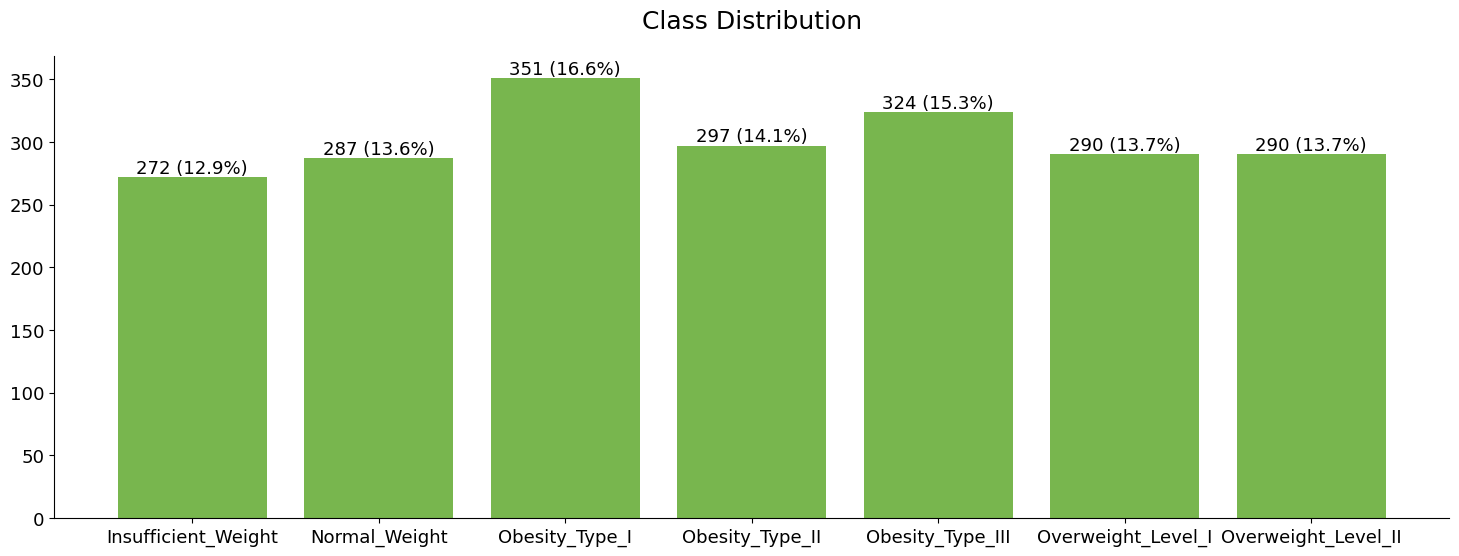

In [15]:
plt.figure(figsize=(18, 6))

data_analysis.class_dist(y, title="Class Distribution", colors=green_color, label_font_size=label_size)

plt.savefig(f"{logs_dir}/obesity_class_dist.png", bbox_inches="tight")
plt.show()

In [7]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [8]:
from sklearn.compose import ColumnTransformer
print(numerical_columns, categorical_columns)

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'] ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [9]:
for col in categorical_columns:
    print(col, np.unique(X[col], return_counts=True))

Gender (array(['Female', 'Male'], dtype=object), array([1043, 1068], dtype=int64))
family_history_with_overweight (array(['no', 'yes'], dtype=object), array([ 385, 1726], dtype=int64))
FAVC (array(['no', 'yes'], dtype=object), array([ 245, 1866], dtype=int64))
CAEC (array(['Always', 'Frequently', 'Sometimes', 'no'], dtype=object), array([  53,  242, 1765,   51], dtype=int64))
SMOKE (array(['no', 'yes'], dtype=object), array([2067,   44], dtype=int64))
SCC (array(['no', 'yes'], dtype=object), array([2015,   96], dtype=int64))
CALC (array(['Always', 'Frequently', 'Sometimes', 'no'], dtype=object), array([   1,   70, 1401,  639], dtype=int64))
MTRANS (array(['Automobile', 'Bike', 'Motorbike', 'Public_Transportation',
       'Walking'], dtype=object), array([ 457,    7,   11, 1580,   56], dtype=int64))


In [10]:
categorical_encoding = {
    "Gender": {"Female": 0, "Male": 1},
    "family_history_with_overweight": {"no": 0, "yes": 1},
    "FAVC": {"no": 0, "yes": 1},
    "CAEC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
    "SMOKE": {"no": 0, "yes": 1},
    "SCC": {"no": 0, "yes": 1},
    "CALC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
    "MTRANS": {"Walking": 0, "Bike": 1, "Motorbike": 2, "Automobile": 3, "Public_Transportation": 4}
}

categorical_decoding = {}

for key in categorical_encoding:
    sub_keys = categorical_encoding[key].keys()
    categorical_decoding[key] = {}
    for sub_key in sub_keys:
        num_value = categorical_encoding[key][sub_key]
        categorical_decoding[key][num_value] = sub_key

In [11]:
def encode_dataset(X, enc_dict):
    X_enc = X
    for key in enc_dict:
        for idx in range(len(X_enc[key])):
            val = X_enc.loc[idx, key]
            X_enc.loc[idx, key] = enc_dict[key][val]
    return X_enc

def decode_dataset(X_enc, dec_dict):
    X_dec = X_enc
    for key in dec_dict:
        for idx in range(len(X_dec[key])):
            val = X_enc.loc[idx, key]
            X_enc.loc[idx, key] = dec_dict[key][val]
    return X_enc
    

In [12]:
X = encode_dataset(X, categorical_encoding)

In [13]:
from sklearn.pipeline import make_pipeline

# enc = OneHotEncoder(handle_unknown='ignore')
# enc = OrdinalEncoder()
# enc.fit(X.iloc[:])
# X = enc.transform(X.iloc[:]).toarray()
# print(X.shape)
# print(enc.inverse_transform([X[0]]))

# preprocessor = ColumnTransformer(
#     [
#         ("one-hot-encoder", enc, [list(X.columns.to_numpy()).index(x) for x in categorical_columns]),
#     ],
#     remainder="passthrough"
# )

X_train_pd, X_test_pd, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = X_train_pd.to_numpy()
X_test = X_test_pd.to_numpy()
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

In [14]:
X_train[0]

array([1, 18.0, 1.74, 86.0, 0, 0, 3.0, 3.0, 1, 0, 2.0, 0, 3.0, 0.0, 0, 4],
      dtype=object)

In [15]:
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(X_train, Y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(max_iter=5000)

Score: 84.07460545193688%


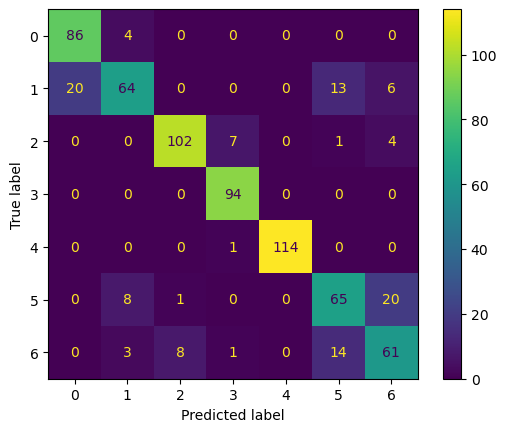

In [16]:
lr_ye = lr_clf.predict(X_test)
lr_cm = confusion_matrix(Y_test, lr_ye)

print(f"Score: {(1 - ((np.sum(lr_ye != Y_test)/len(Y_test)))) * 100}%")

lr_cm_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm)
lr_cm_display.plot()

# lr_y2d = lr_clf.predict_proba(X_test)[:, 1]
# plot_PR(Y_test, lr_cm, lr_y2d)
# plot_ROC(Y_test, lr_cm, lr_y2d)

In [17]:
print(f"Instância:\n {X_test[0]}\n\nClasse: {Y_test[0]}")
print(type(X_test[0][1]))
X_train.shape, features_names.shape

Instância:
 [0 20.406871 1.755978 53.699561 1 1 2.0 3.891994 2 0 1.86393 0 2.870127
 2.0 0 4]

Classe: Insufficient_Weight
<class 'float'>


((1414, 16), (16,))

## Extract Explanations

### <i>Local Model-Agnostic Explanations</i> (LIME)

In [18]:
lr_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
lr_LIME_explanation = lr_LIME_explainer.explain_instance(X_test[0], lr_clf.predict_proba)

In [19]:
lr_LIME_explanation.show_in_notebook(show_table=True)

In [20]:
lr_LIME_explanation.local_pred

array([0.47066142])

### <i>SHapley Additive exPlanations</i> (SHAP)

In [21]:
shap.initjs()

In [22]:
lr_SHAP_exp = shap.KernelExplainer(lr_clf.predict_proba, shap.sample(X_train_pd, 10))
lr_shap_values = np.array(lr_SHAP_exp.shap_values(X_test_pd.iloc[0, :]))

In [23]:
lr_shap_values.shape, lr_SHAP_exp.expected_value.shape

((7, 16), (7,))

#### Explain instance first test instance for each class

Class 0


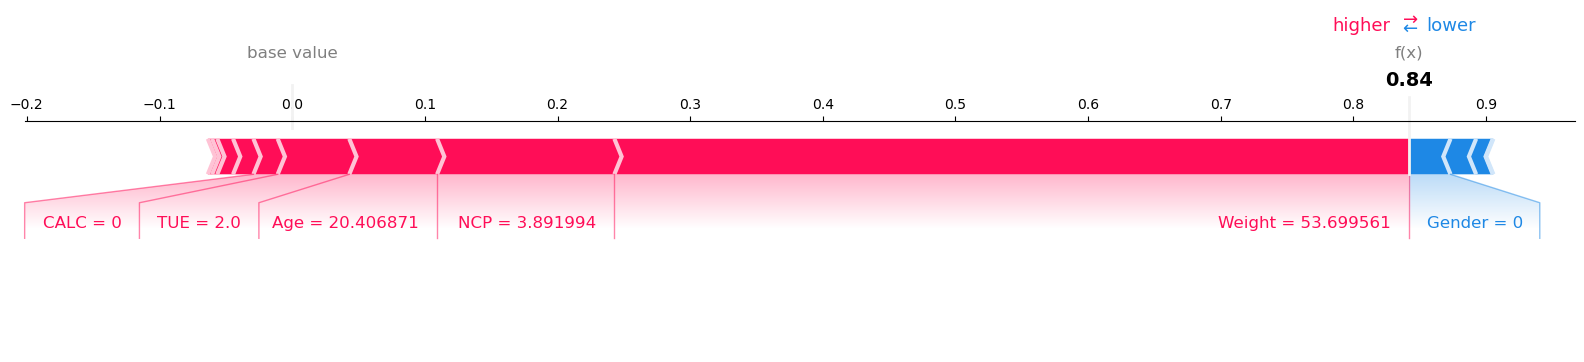

Class 1


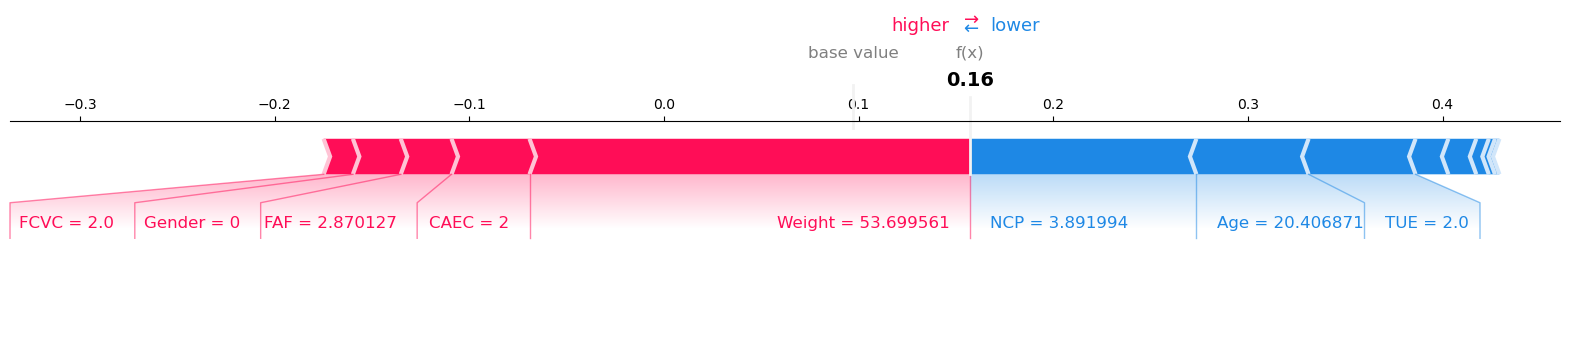

Class 2


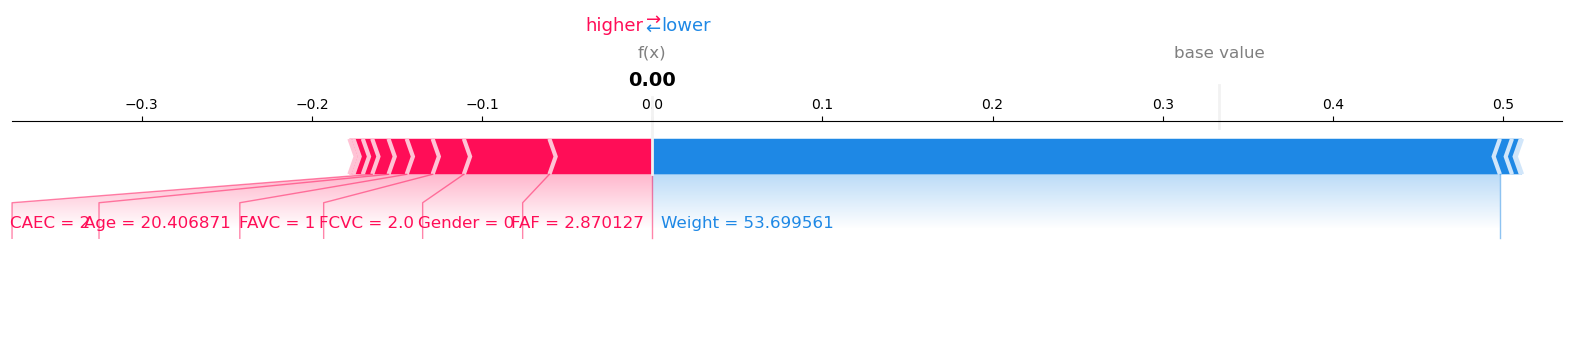

Class 3


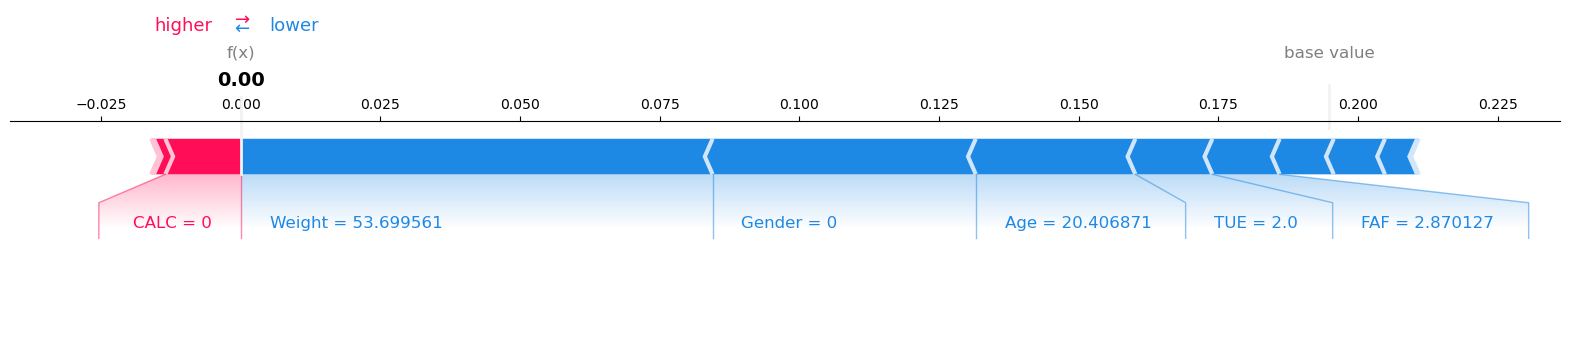

Class 4


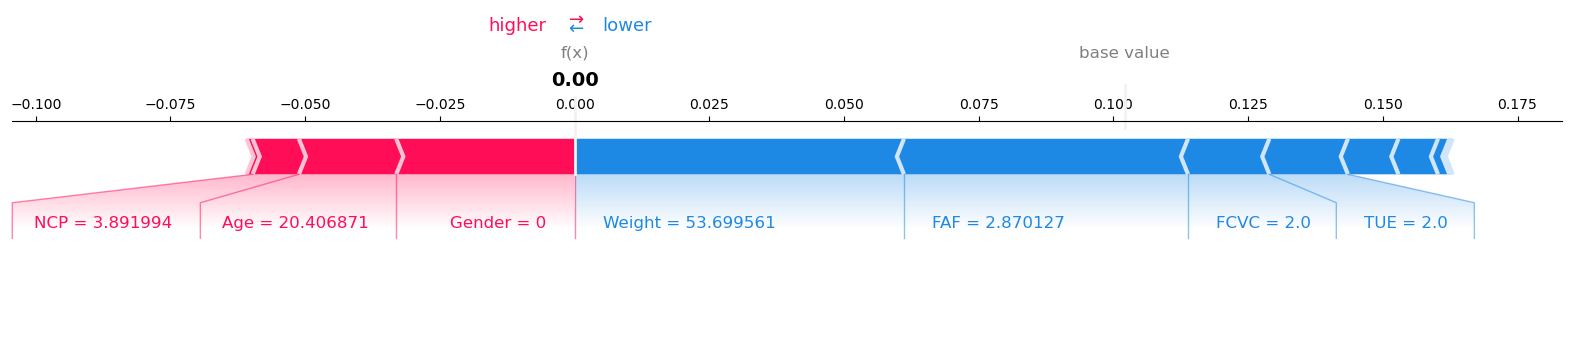

Class 5


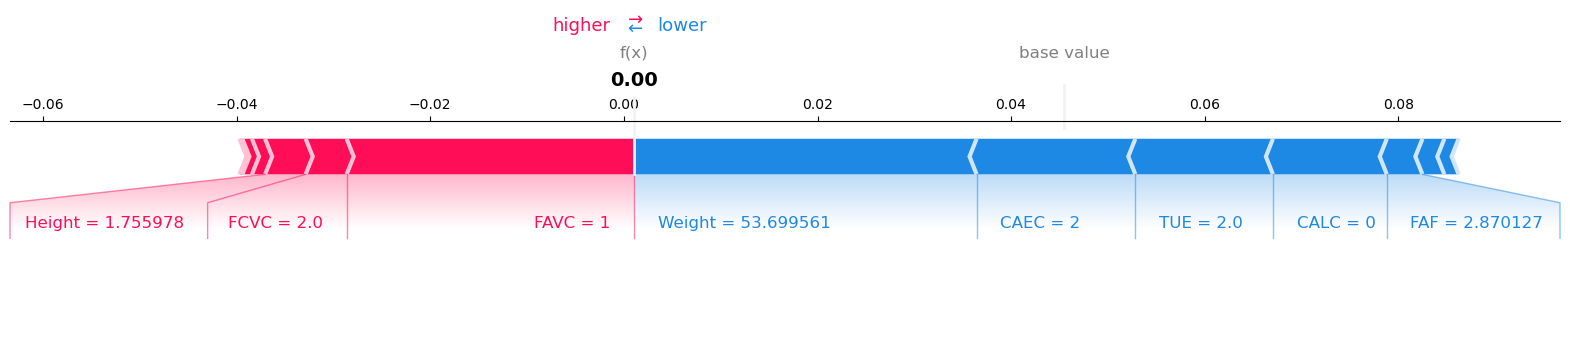

Class 6


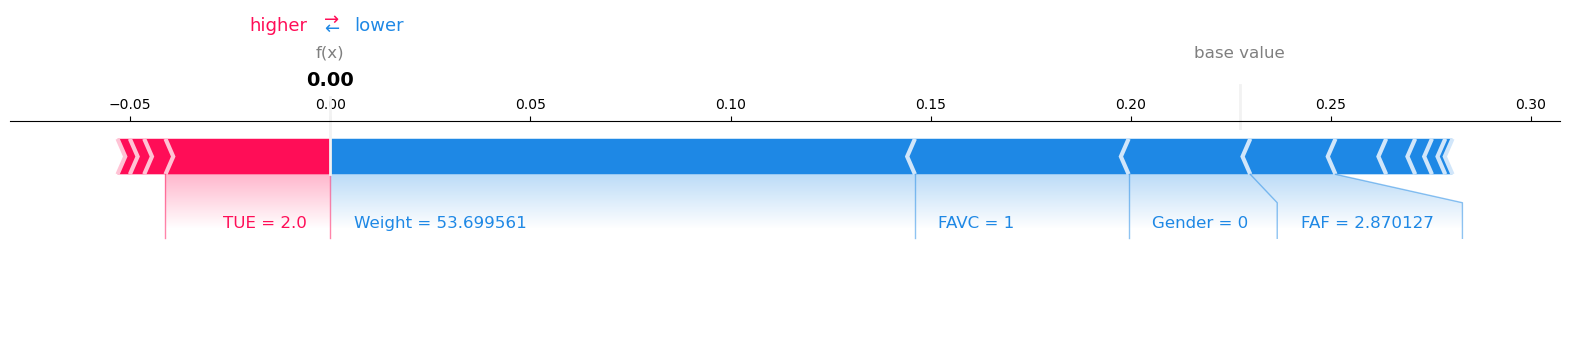

In [24]:
for i in range(len(np.unique(Y_train))):
    print(f"Class {i}")
    shap.force_plot(lr_SHAP_exp.expected_value[i], lr_shap_values[i,:], X_test_pd.iloc[0, :], matplotlib=True)

## Train the Model - <i>Random Forest</i> (RF)

In [25]:
rf_clf = RandomForestClassifier().fit(X_train, Y_train)

Score: 93.4002869440459%


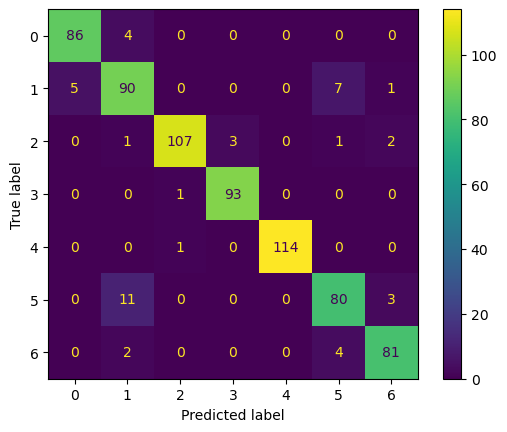

In [26]:
rf_ye = rf_clf.predict(X_test)
rf_cm = confusion_matrix(Y_test, rf_ye)

print(f"Score: {(1 - ((np.sum(rf_ye != Y_test)/len(Y_test)))) * 100}%")

rf_cm_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm)
rf_cm_display.plot()


# rf_y2d = rf_clf.predict_proba(X_test)[:, 1]
# compare_PR([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])
# compare_ROC([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])

## Extract Explanations


### <i>Local Model-Agnostic Explanations</i> (LIME)

In [27]:
rf_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
rf_LIME_explanation = rf_LIME_explainer.explain_instance(X_test[0], rf_clf.predict_proba)

In [28]:
rf_LIME_explanation.show_in_notebook(show_table=True)

### <i>SHapley Additive exPlanations</i> (SHAP)

In [29]:
rf_SHAP_exp = shap.KernelExplainer(rf_clf.predict_proba, shap.sample(X_train_pd, 10))
rf_shap_values = np.array(rf_SHAP_exp.shap_values(X_test_pd.iloc[0, :]))

Class 0


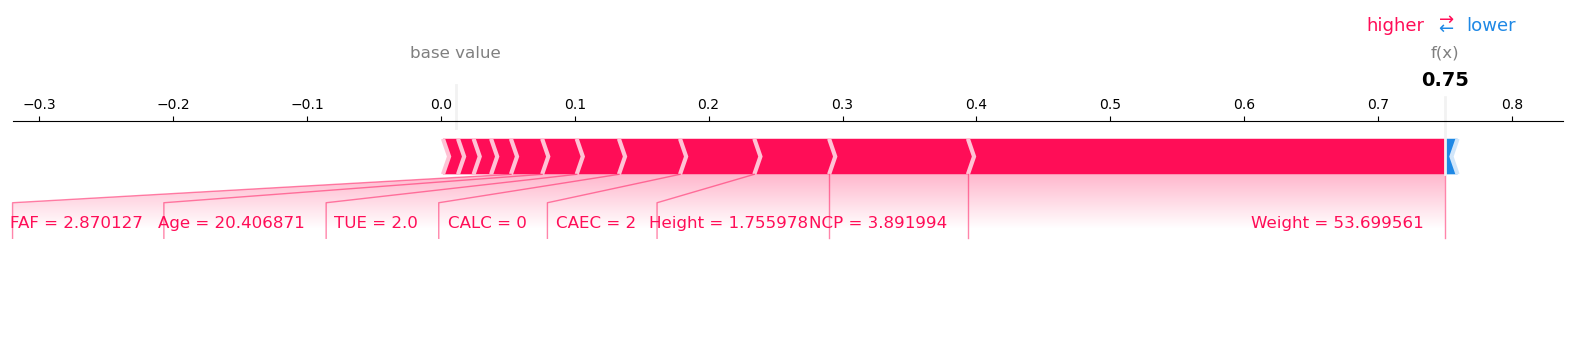

Class 1


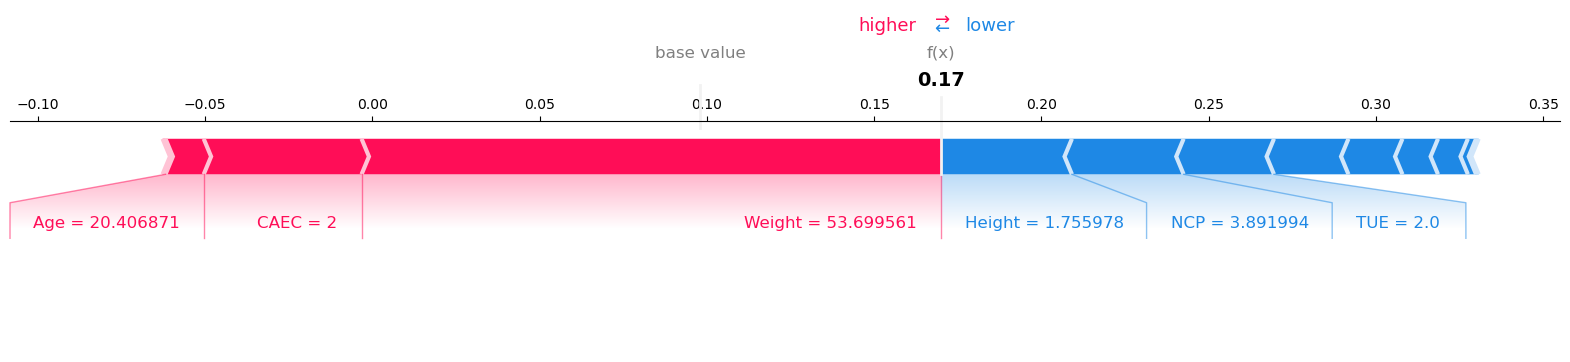

Class 2


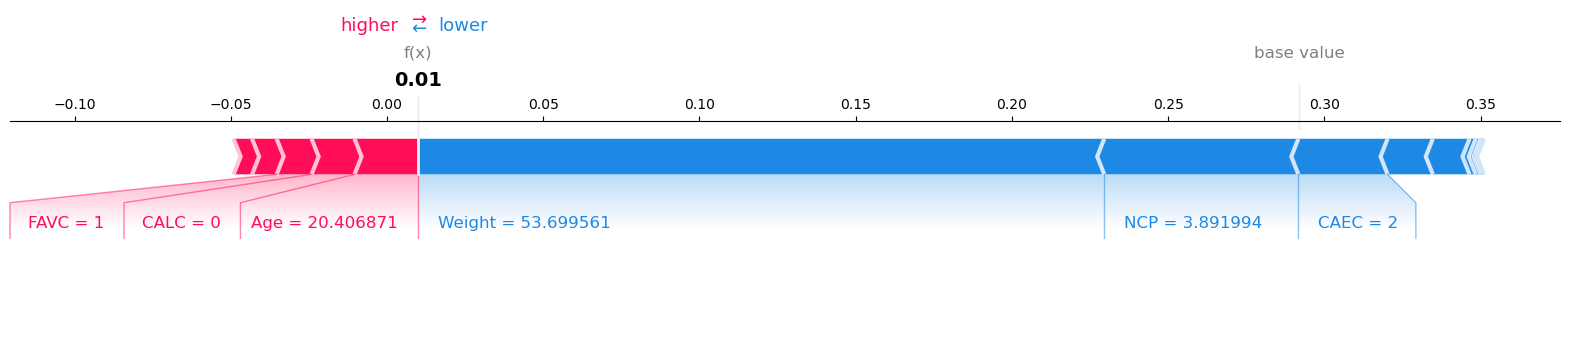

Class 3


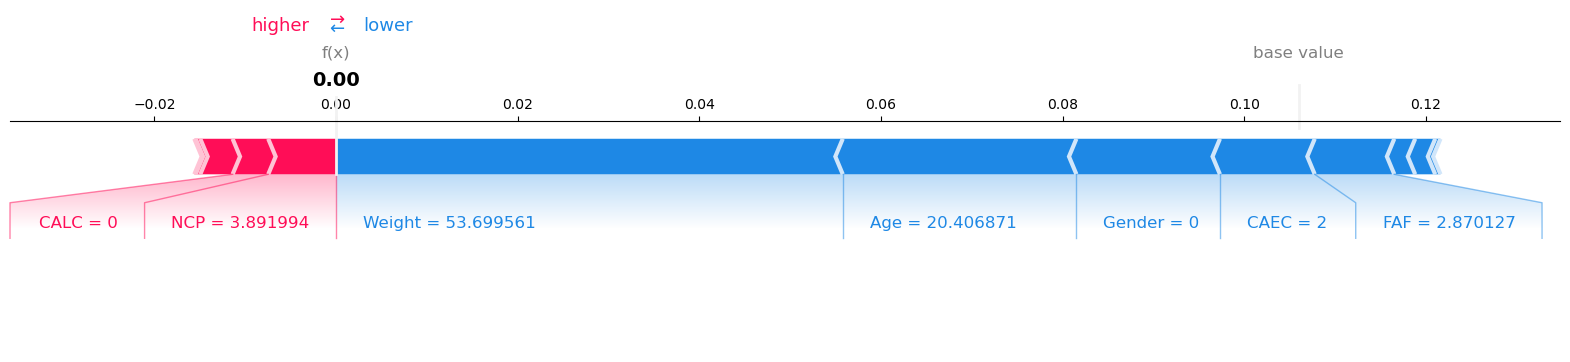

Class 4


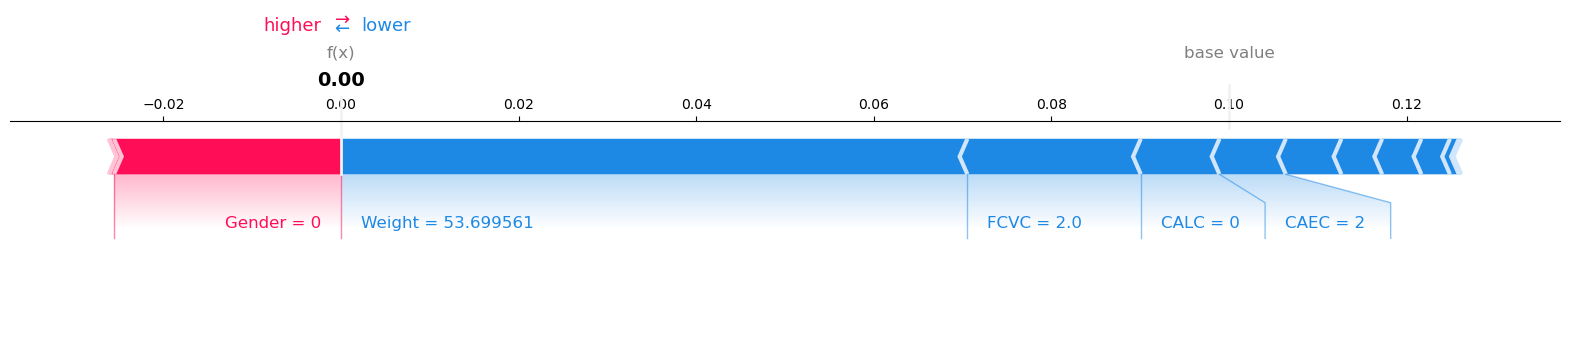

Class 5


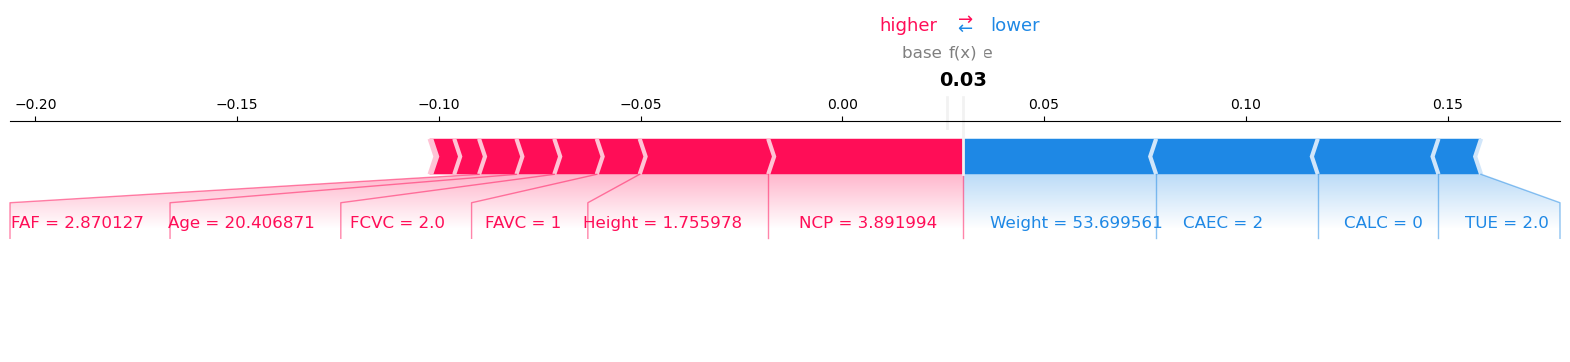

Class 6


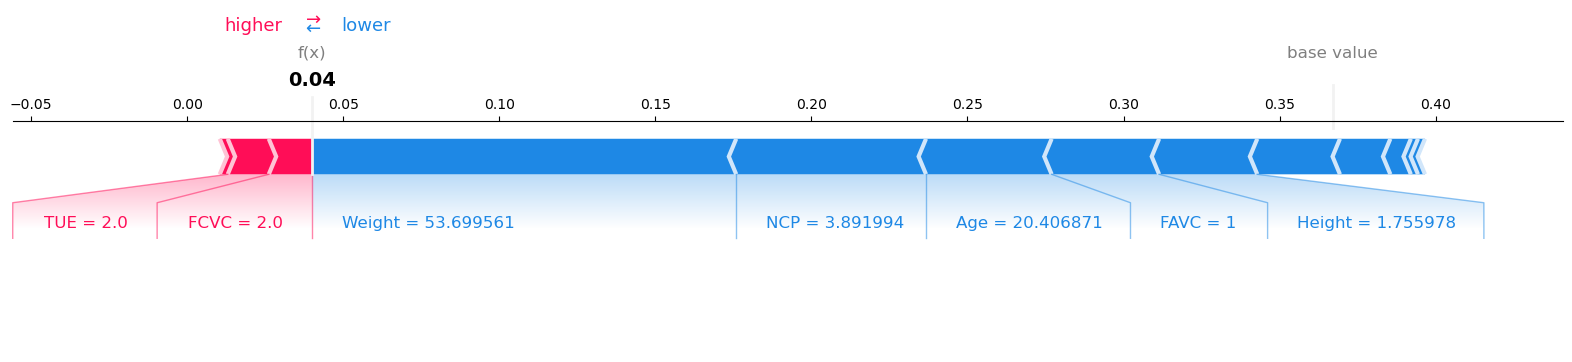

In [30]:
for i in range(len(np.unique(Y_train))):
    print(f"Class {i}")
    shap.force_plot(rf_SHAP_exp.expected_value[i], rf_shap_values[i,:], X_test_pd.iloc[0, :], matplotlib=True)

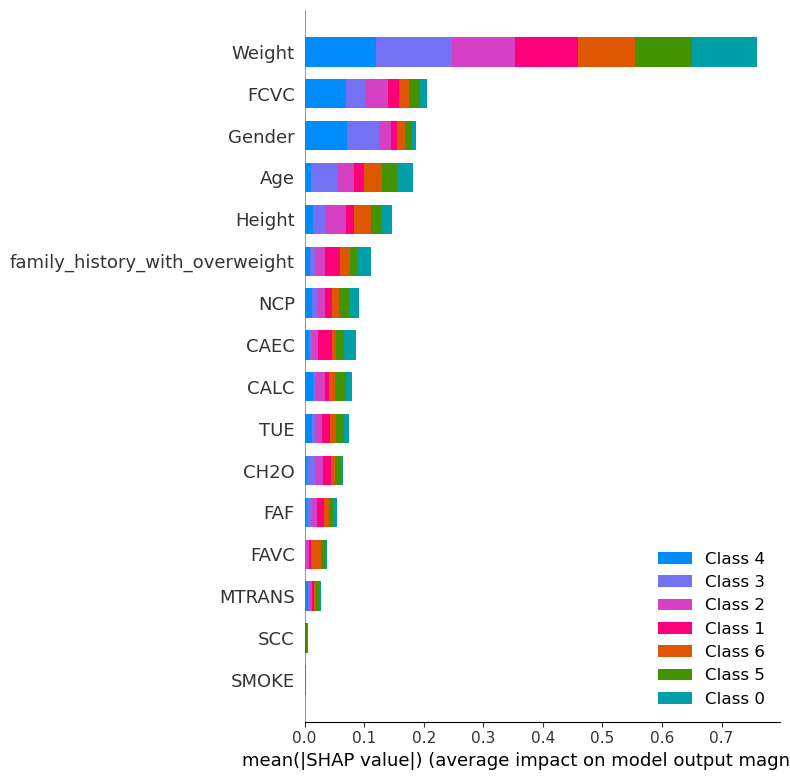

In [31]:
explainer = shap.Explainer(rf_clf)
rf_shap_values = explainer.shap_values(X_test_pd)
shap.summary_plot(rf_shap_values, X_test_pd, plot_type="bar")

In [32]:
# for var_name in features_names:
#     shap.dependence_plot(var_name, rf_shap_values[1], X_test_pd, feature_names=features_names)

# Train SVM

In [175]:
from sklearn.svm import SVC

In [176]:
svm_clf = SVC(probability=True).fit(X_train, Y_train)

Score: 52.22381635581061%


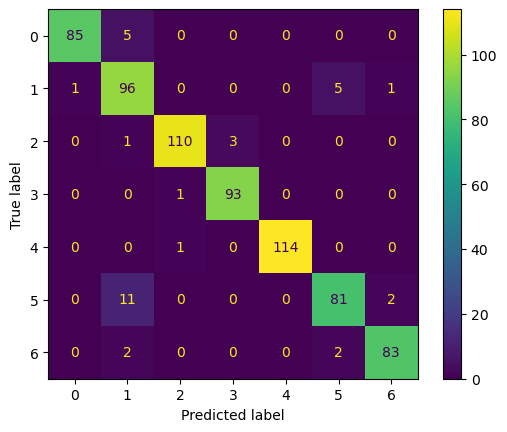

In [177]:
svm_ye = svm_clf.predict(X_test)
svm_cm = confusion_matrix(Y_test, rf_ye)

print(f"Score: {(1 - ((np.sum(svm_ye != Y_test)/len(Y_test)))) * 100}%")

svm_cm_display = ConfusionMatrixDisplay(confusion_matrix = svm_cm)
svm_cm_display.plot()
# svm_y2d = svm_clf.decision_function(X_test)
# compare_PR([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR", "RF", "SVM"])
# compare_ROC([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR","RF", "SVM"])
# print(svm_y2d)

## Extract Explanations


### <i>Local Model-Agnostic Explanations</i> (LIME)

In [178]:
svm_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
svm_LIME_explanation = svm_LIME_explainer.explain_instance(X_test[0], svm_clf.predict_proba)

In [179]:
svm_LIME_explanation.show_in_notebook(show_table=True)

### <i>SHapley Additive exPlanations</i> (SHAP)

In [180]:
svm_SHAP_exp = shap.KernelExplainer(svm_clf.predict_proba, shap.sample(X_train_pd, 10))
svm_shap_values = np.array(svm_SHAP_exp.shap_values(X_test_pd.iloc[0, :]))

Class 0


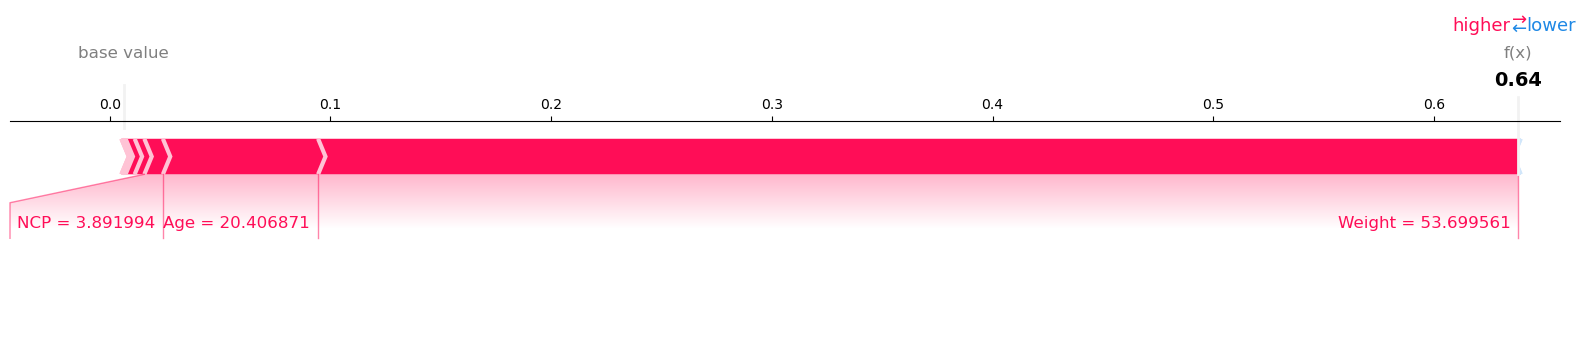

Class 1


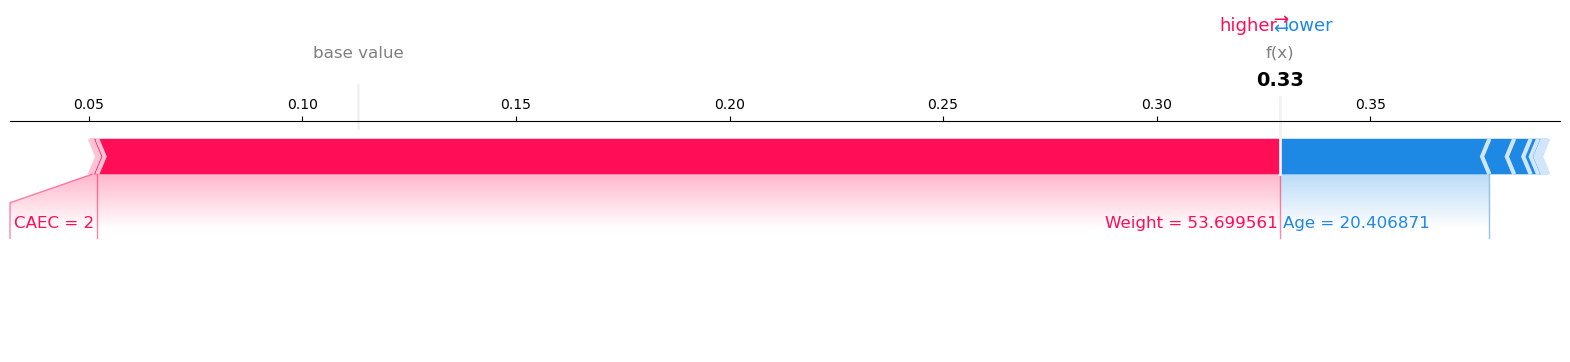

Class 2


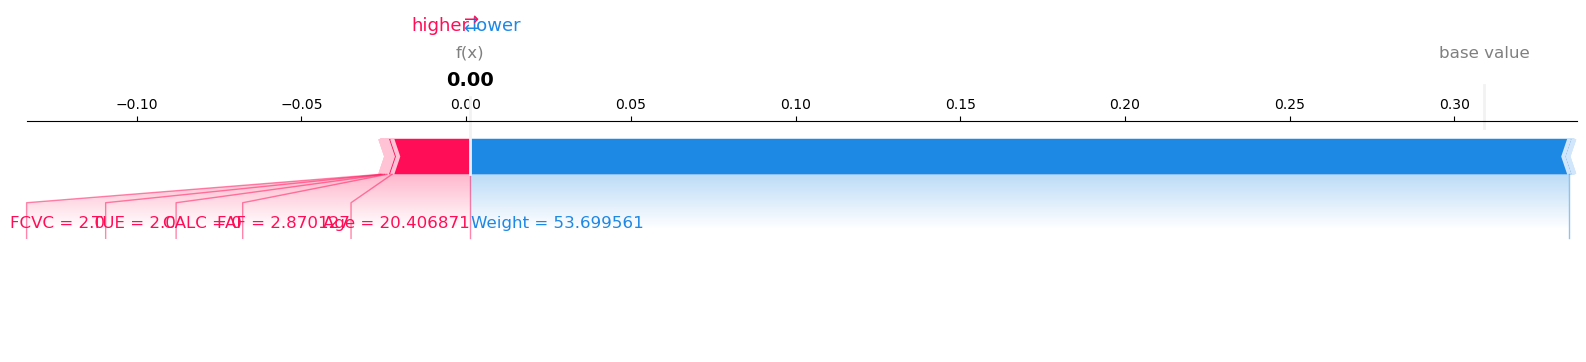

Class 3


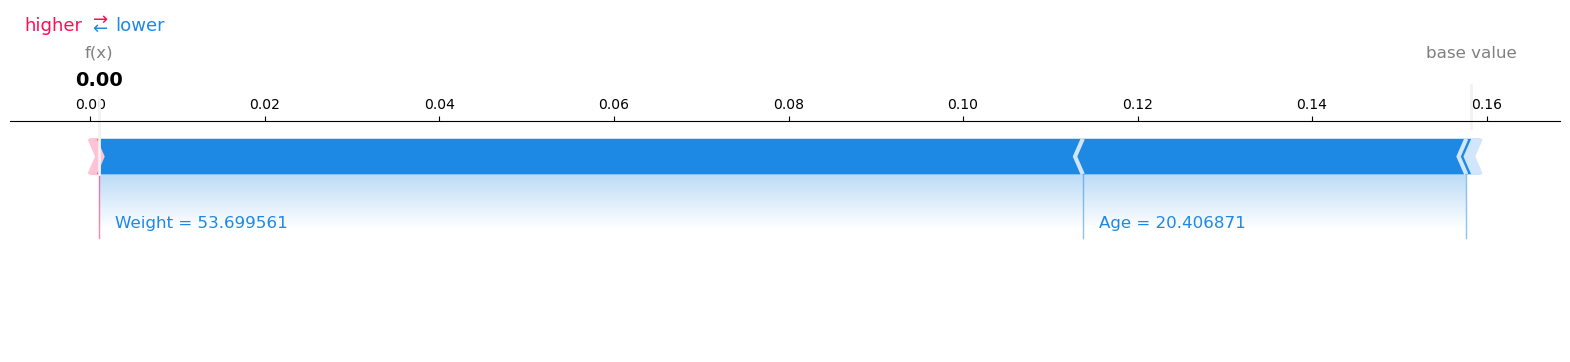

Class 4


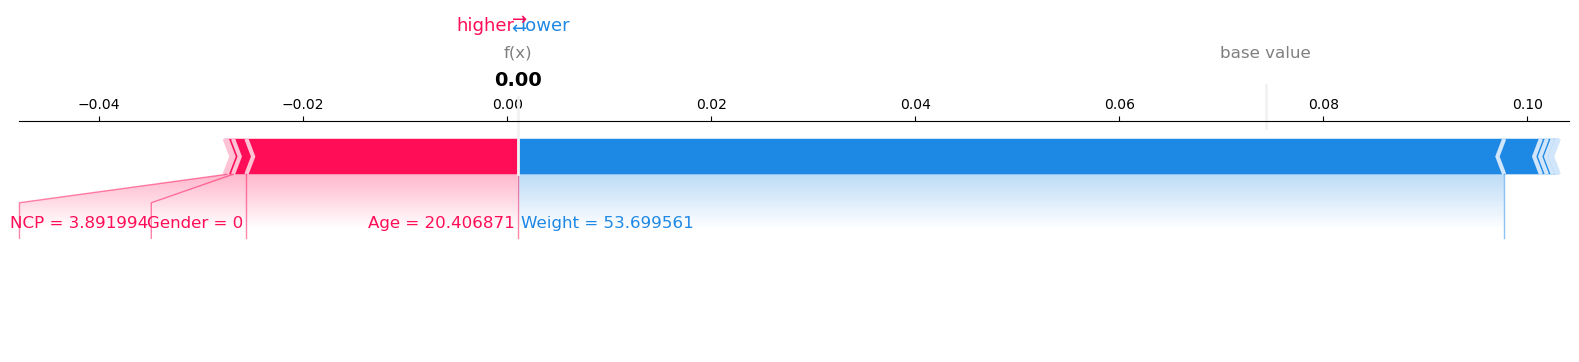

Class 5


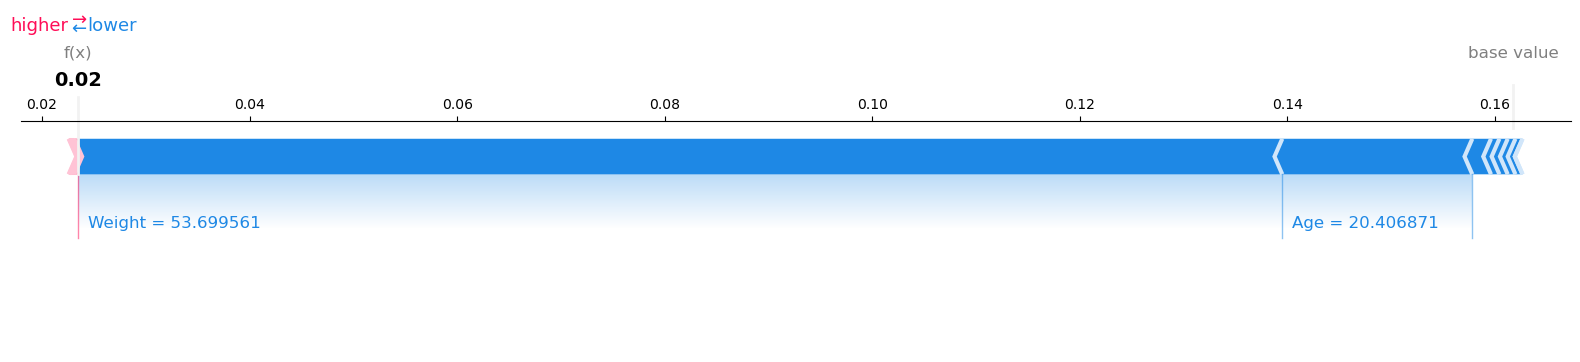

Class 6


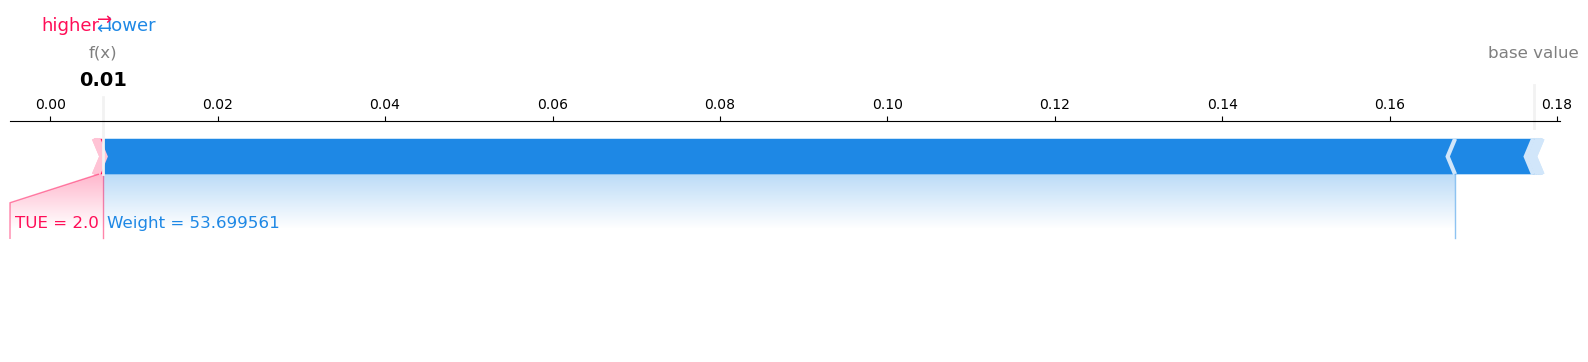

In [181]:
for i in range(len(np.unique(Y_train))):
    print(f"Class {i}")
    shap.force_plot(svm_SHAP_exp.expected_value[i], svm_shap_values[i,:], X_test_pd.iloc[0, :], matplotlib=True)

## <i>Train Explainable Boosting Machine</i> (EBM)

In [182]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train_pd, Y_train)

ebm.score(X_test_pd, Y_test)

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.


0.9340028694404591

### Extract Explanations

### Global

In [183]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/1808428062096/ -->